In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
# Step 1: Fetch historical stock price data for AAPL
data = yf.download('TSLA', start='2020-01-01', end='2025-07-05')
df = data[['Close']].copy()
df.columns = ['price']

[*********************100%***********************]  1 of 1 completed


In [82]:
#Step 2: Calculate daily return, 20-day SMA, and standard deviation
df['daily_return'] = df['price'].pct_change()
window = 20
df['sma'] = df['price'].rolling(window=window).mean()
df['std_dev'] = df['price'].rolling(window=window).std()
df['lower_band'] = df['sma'] - (1.6 * df['std_dev']) # Threshold: 1 standard deviation below SMA

In [83]:
#Step 3 & 4: Define trading signals and simulate positions
position = []
in_position = False

for i in range(len(df)):
    if i < window: # Skip first 20 days due to NaN in rolling calculations
        position.append(0)
        continue

    price = df['price'].iloc[i]
    sma = df['sma'].iloc[i]
    lower_band = df['lower_band'].iloc[i]

    if not in_position and price < lower_band:
        in_position = True      # Buy Signal: price below lower band
    elif in_position and price >= sma:
        in_position = False     # Sell Singal: price equal or above sma

    position.append(1 if in_position else 0)

df['position'] = position

df.head(30)

,price,daily_return,sma,std_dev,lower_band,position
Date,,,,,,
2020-01-02,28.684000,NaN,NaN,NaN,NaN,0
2020-01-03,29.534000,0.029633,NaN,NaN,NaN,0
2020-01-06,30.102667,0.019255,NaN,NaN,NaN,0
2020-01-07,31.270666,0.038801,NaN,NaN,NaN,0
2020-01-08,32.809334,0.049205,NaN,NaN,NaN,0
2020-01-09,32.089333,-0.021945,NaN,NaN,NaN,0
2020-01-10,31.876667,-0.006627,NaN,NaN,NaN,0
2020-01-13,34.990665,0.097689,NaN,NaN,NaN,0
2020-01-14,35.861332,0.024883,NaN,NaN,NaN,0


In [84]:
# Step 5: Calculate strategy returns
# Position at close of day i-1 determines return on day i
df['strategy_return'] = df['position'].shift(1) * df['daily_return']
df['strategy_return'] = df['strategy_return'].fillna(0) # Fill NaN with 0 for days with no position

# Calculate cumulative return for strategy and buy-and-hold
df['cum_strategy_retun'] = (1 + df['strategy_return']).cumprod() - 1
df['cum_bh_return'] = (1 + df['daily_return']).cumprod() - 1

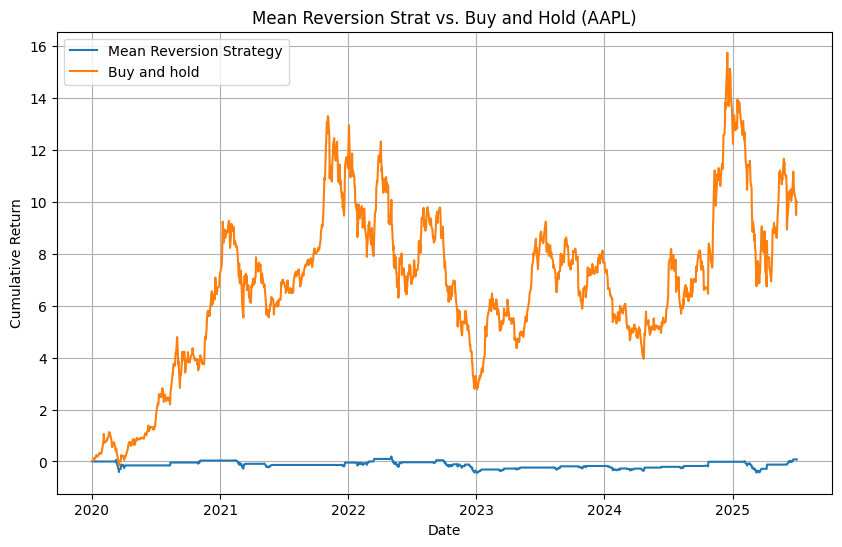

Strategy Total Return: 7.905%
Buy and Hold Total Return: 999.393%
Strategy Sharpe Ratio: 0.234


In [85]:
# Step 6: Visualize the results
plt.figure(figsize = (10,6))
plt.plot(df.index, df['cum_strategy_retun'], label = "Mean Reversion Strategy")
plt.plot(df.index, df['cum_bh_return'], label = 'Buy and hold')
plt.title('Mean Reversion Strat vs. Buy and Hold (AAPL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

strategy_total_return = df['cum_strategy_retun'].iloc[-1]
bh_total_return = df['cum_bh_return'].iloc[-1]
strategy_sharpe = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)

print(f"Strategy Total Return: {strategy_total_return:.3%}")
print(f"Buy and Hold Total Return: {bh_total_return:.3%}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.3f}")